<a href="https://colab.research.google.com/github/MarcinAn/Przestepczosc/blob/main/Przestepczosc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pobieranie danych**

In [271]:
import pandas as pd
df= pd.read_csv('fatal-police-shootings-data.csv')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


**Przekształć tabelę w taki sposób, aby wskazywała zestawienie jednocześnie liczby ofiar interwencji według rasy (‘race’) oraz tego, czy wykazywały one oznaki choroby psychicznej (‘signs_of_mental_illness’).**

In [308]:
import numpy as np
mental_illness = df.pivot_table(values= 'name', index= 'race', columns= 'signs_of_mental_illness', aggfunc= 'count')
mental_illness

signs_of_mental_illness,False,True
race,,
A,69,24
B,1114,184
H,745,157
N,64,14
O,37,11
W,1763,713


**Za pomocą Map, Applymap lub Apply dodaj do tego zestawienia kolumnę wskazującą jaki odsetek ofiar interwencji wykazywało oznaki choroby psychicznej dla każdej z ras. Odpowiedz, która z nich charakteryzuje się największym odsetkiem znamion choroby psychicznej podczas interwencji.**

In [311]:
mental_illness_counter= mental_illness.reset_index()
mental_illness_counter


signs_of_mental_illness,index,race,False,True
0,0,A,69,24
1,1,B,1114,184
2,2,H,745,157
3,3,N,64,14
4,4,O,37,11
5,5,W,1763,713


In [315]:
def mental_illnes_intervention(row):
  return round(row[True]/(row[True]+row[False]), 2)

mental_illness_counter['count'] = mental_illness_counter.apply(lambda row: mental_illnes_intervention(row), axis=1)

<Axes: xlabel='race'>

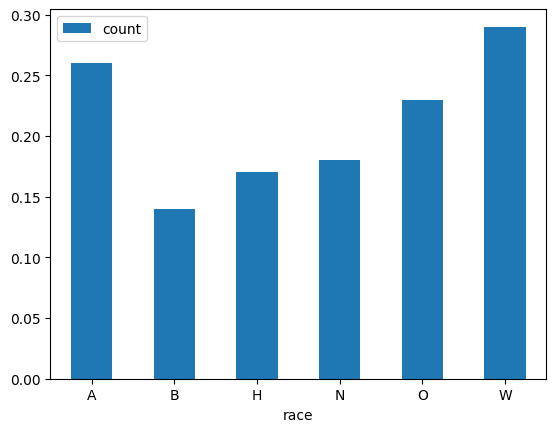

In [314]:
mental_illness_counter.plot.bar(x= 'race', y= 'count', rot= 0)

**Dodaj kolumnę oznaczającą dzień tygodnia, w którym doszło do interwencji. Zlicz interwencje według odpowiedniego dnia tygodnia. Następnie stwórz wykres kolumnowy, tak aby dni tygodnia były uszeregowane od poniedziałku do niedzieli.**

In [316]:
df['Day'] = pd.to_datetime(df['date']).dt.day_name()
plot = df.pivot_table(values = 'name', index = 'Day', aggfunc = 'count')
plot = plot.reset_index()

def set_day_number(x):
  if x == 'Monday':
    return '1'
  elif x == 'Tuesday':
    return '2'
  elif x == 'Wednesday':
    return '3'
  elif x == 'Thursday':
    return '4'
  elif x == 'Friday':
    return '5'
  elif x == 'Saturday':
    return '6'
  elif x == 'Sunday':
    return '7'
plot['Day_nr'] = plot['Day'].apply(lambda x: set_day_number(x))
plot = plot.sort_values(by = 'Day_nr')
plot

,Day,name,Day_nr
1,Monday,726,1
5,Tuesday,816,2
6,Wednesday,829,3
4,Thursday,810,4
0,Friday,761,5
2,Saturday,721,6
3,Sunday,753,7


In [ ]:
plot.plot.bar(x = 'Day', y = 'name', rot = 0)

**Wczytaj do projektu dane dotyczące populacji w poszczególnych stanach USA oraz dane dotyczące skrótów poszczególnych stanów. Połącz te bazy danych w taki sposób, aby móc policzyć do ilu incydentów w bazie dotyczącej śmiertelnych interwencji doszło w przeliczeniu na 1000 mieszkańców każdego ze stanów.**

In [ ]:
usa_states = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations', header=0)[0]
usa_states=usa_states.iloc[:,[0,5]]
usa_states.rename(columns = {usa_states.columns[0]:'State', usa_states.columns[1]:'Code'}, inplace=True)
usa_states.dropna(axis=0, inplace=True)

In [ ]:
usa_population = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population', header = 0)[0]
usa_population = usa_population[{'State', 'Census population, April 1, 2020 [1][2]'}]
usa_population.rename(columns = {usa_population.columns[0]:'State', usa_population.columns[1]:'Population'}, inplace=True)

In [ ]:
state_population_and_symbol = pd.merge(usa_population,usa_states,how='inner',on='State')
state_population_and_symbol.set_index(['Code'], inplace=True)

In [ ]:
def assign_state_symbol(x):
  return state_population_and_symbol.loc[x,'Population']

def bonus(row):
  return round((row['victim'] / row['population']) * 1000, 2)

count = df.pivot_table(values = 'name', index = 'state', aggfunc = 'count')
count.rename(columns = {'name': 'victim'}, inplace=True)
count.reset_index(inplace = True)
count['population'] = count['state'].apply(lambda x: assign_state_symbol(x))
count['On 1000 case'] = count.apply(lambda row: bonus(row),axis = 1)
count
